In [1]:
push!(LOAD_PATH,"../../../ExoJulia/")

include("../../hw2/Jake_Dave/utils.jl")
include("../../hw2/Jake_Dave/orbital_utils.jl")
include("../../hw2/Jake_Dave/rv.jl")
include("transit_utils.jl")

using ExoJulia
using PyPlot
using LsqFit
using Optim
using Lora

# Read in the data

In [2]:
data = readdlm("mystery_planet2.txt");
time = data[:,1];
flux = data[:,2];
mean_flux = flux/median(flux)
err = data[:,3];

# What's the data look like?

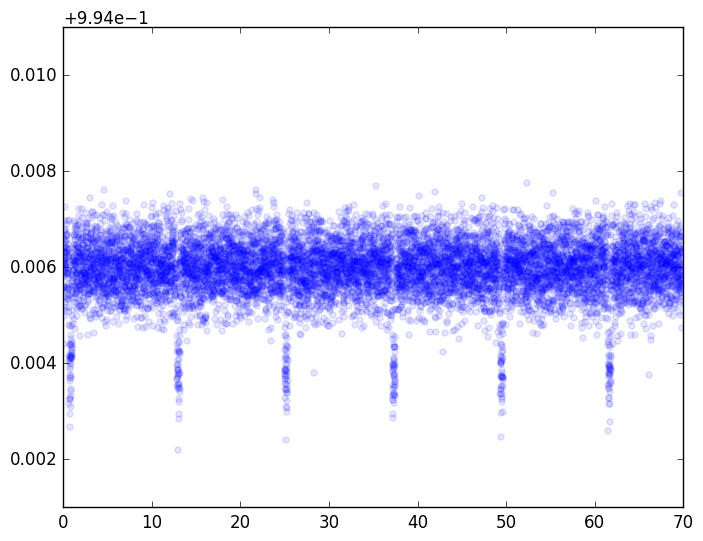

(0.0,69.992996)

In [3]:
scatter(time,mean_flux, color="blue", alpha=0.1)
ylim(0.995,1.005)
xlim(minimum(time),maximum(time))

# Use Agol Periodogram to estimate the period

In [4]:
periods = collect(linspace(10.0,13.0,1000))

best_period = agol_periodogram(data, periods)

12.168168168168169

# Phase fold with the fitted period to see if it works.

In [5]:
data_fold = copy(data)
data_fold[:,1] = mod(time - time[1], best_period);
data_fold = fastsortrows(data_fold,[1]);

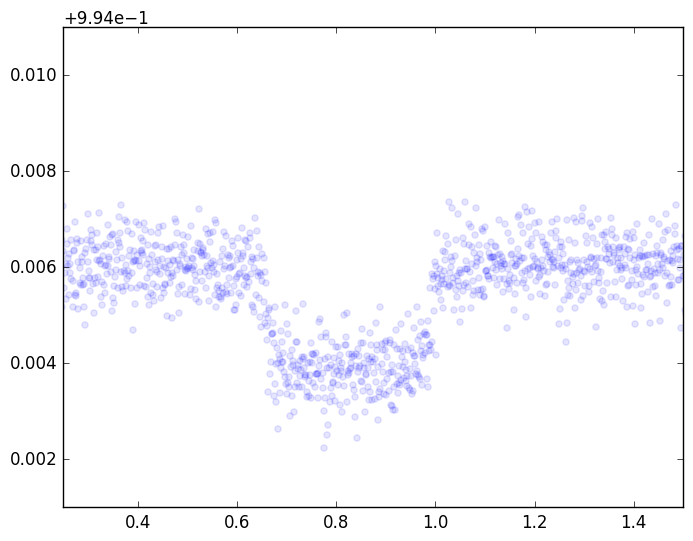

(0.25,1.5)

In [6]:
scatter(data_fold[:,1],data_fold[:,2]/mean(data_fold[:,2]),color="blue",alpha=0.1)
ylim(0.995,1.005)
#xlim(minimum(data_fold[:,1]),maximum(data_fold[:,1]))
xlim(0.25,1.5)

### We want to calculate the first time that elapses between the first observation and the center of the first transit, $t_{off}$.

In [13]:
function estimate_toff_rprs(time::Array{Float64,1},flux::Array{Float64,1},period::Float64)
    best_ind = argmin(abs(time-period))
    toff_est_ind = argmin(flux[1:best_ind])
    mf = median(flux)
    tmp = 1.0 - flux[toff_est_ind]/mf
    
    return time[toff_est_ind], tmp
end

estimate_toff_rprs (generic function with 1 method)

In [16]:
best_toff, best_rprs = estimate_toff_rprs(time,flux,best_period)

(0.784,0.003316800168104317)

# Transit logliklihood and forward model

In [ ]:
function transit_loglike(params::Vector)
    # params = [rp/rs, d, ecc, varpi, inc, period] where d = a/rstar
    
    # Hard bounds
    if params[1] < 0.0 || params[1] >= 0.1
        return Inf
    end
    if params[2] <= 0.0
        return Inf
    end
    if params[3] < 0.0 || params[3] >= 1.0
        return Inf
    end
    if(params[4] < 0.0) || (params[4] > 2.0*pi)
        return Inf
    end
    if (params[5] > (100.0*pi/180.0)) || (params[5] < (80.0*pi/180.0))
        return Inf
    end
    if(params[6] <= 0.0)
        return Inf
    end
    # Probability of transit must be between (0,1]
    if (1./params[2])*(params[1] + 1.)/(1.0-params[3]^2.) <= 0.0
        return Inf
    end
    if (1./params[2])*(params[1] + 1.)/(1.0-params[3]^2.) > 1.0
        return Inf
    end
    
    # Note: - because optim looks for MINIMUM!
    model = transit_model(time,params);
    
    return -loglike(mean_flux, model, err);
end

In [ ]:
function transit_model(time::Array{Float64,1},params::Vector)
    # params = [rp/rs, d, ecc, varpi, inc, period, tp] where d = a/rstar
    k = params[1]
    d = params[2]
    ecc = params[3]
    varpi = params[4] + pi/2.0 # rads
    inc = params[5]
    per = params[6]
    tp = params[7]
    
    #fi = 3.*pi/2 - varpi
    #tp = per*sqrt(1.-ecc*ecc)/(2.*pi)*(ecc*sin(fi)/(1.+ecc*cos(fi))-2./sqrt(1.-ecc*ecc)*atan2(sqrt(1.-ecc*ecc)*tan(fi/2.),1.+ecc))
    
    rel_flux = zeros(length(time))
    distance = 0.0
    for i=1:length(time)
        distance = center_separation(time[i],time[1]+tp,per,d,inc,ecc,varpi)
        rel_flux[i] = relative_flux(distance,k)
    end
    
    return rel_flux
end

# Transit logliklihood and forward model used for Lora MCMC fitting

In [ ]:
function transit_model_mcmc(time::Array{Float64,1},params::Vector)
    # params = [rp/rs, d, ecc, varpi, inc, period, tp] where d = a/rstar
    k = params[1]
    d = params[2]
    ecc = params[3]
    varpi = params[4] + pi/2.0 # rads
    inc = params[5]
    per = params[6]
    tp = params[7]
    
    #fi = 3.*pi/2 - varpi
    #tp = per*sqrt(1.-ecc*ecc)/(2.*pi)*(ecc*sin(fi)/(1.+ecc*cos(fi))-2./sqrt(1.-ecc*ecc)*atan2(sqrt(1.-ecc*ecc)*tan(fi/2.),1.+ecc))
    
    rel_flux = zeros(length(time))
    distance = 0.0
    for i=1:length(time)
        distance = center_separation(time[i],time[1]+tp,per,d,inc,ecc,varpi)
        rel_flux[i] = relative_flux(distance,k)
    end
    
    return rel_flux
end

In [ ]:
function transit_loglike_mcmc(params::Vector)
    # params = [rp/rs, d, ecc, varpi, inc, period, tp] where d = a/rstar
    
    # Hard bounds
    if params[1] < 0.0 || params[1] >= 0.1
        return -Inf
    end
    if params[2] <= 0.0
        return -Inf
    end
    if params[3] < 0.0 || params[3] >= 1.0
        return -Inf
    end
    if(params[4] < 0.0) || (params[4] > 2.0*pi)
        return -Inf
    end
    if (params[5] > (105.0*pi/180.0)) || (params[5] < (75.0*pi/180.0))
        return -Inf
    end
    if params[6] <= (best_period - 0.1) || params[6] > (best_period + 0.1)
        return -Inf
    end
    if params[7] < 0.0 || params[7] > params[6]
        return -Inf
    end
    # Probability of transit must be between (0,1]
    if (1./params[2])*(params[1] + 1.)/(1.0-params[3]^2.) <= 0.0
        return -Inf
    end
    if (1./params[2])*(params[1] + 1.)/(1.0-params[3]^2.) > 1.0
        return -Inf
    end
    
    # Note: - because optim looks for MINIMUM!
    model = transit_model_mcmc(time,params);
    
    return loglike(mean_flux, model, err);
end

function transit_loglike_optim(params::Vector)
    return -transit_loglike_mcmc(params)
end

# Try fitting this model with optim

In [ ]:
# [rp/rs, d, ecc, varpi, inc, period]
params = [0.05, 20.0, 0.1, 0.1, pi/2.0, best_period]
optimum = optimize(transit_loglike_optim, params, autodiff=true)

In [ ]:
best_optim = optimum.minimum

# Try MCMC for orbital elements model

In [ ]:
p = BasicContMuvParameter(:p, logtarget=transit_loglike_mcmc)

model = likelihood_model(p, false)

# initial guess # params [rp/rs, d, ecc, varpi, inc, period]
params = [0.05, 20.0, 0.1, 0.1, pi/2.0, best_period, 1.0]

sampler = MH(ones(length(params)))

N = 10000000
mcrange = BasicMCRange(nsteps=N, burnin=(N-10000))

v0 = Dict(:p=>params)

job = BasicMCJob(model, sampler, mcrange, v0, tuner=tuner=AcceptanceRateMCTuner(0.1, verbose=false))

run(job)

chain = output(job)

### Check that the simulated values are close to the zero-mean target

best_mcmc = mean(chain)

In [ ]:
time_hires = collect(linspace(minimum(time),maximum(time),100000))

scatter(time_hires,transit_model_mcmc(time_hires,best_mcmc),color="green", alpha=0.1)

#scatter(time,mean_flux, color="blue", alpha=0.1)
ylim(0.995,1.005)

# Impact parameter formalization

In [17]:
function impact_separation(b::Float64,t::Float64,v::Float64,P::Float64,toff::Float64)
    return sqrt(b^2 + (v.*(mod(t,P)-toff)).^2)
end

impact_separation (generic function with 1 method)

In [18]:
function transit_model_impact(time::Array{Float64,1},params::Vector)
    # params [rp/rs, b, v, period, toff]
    
    rel_flux = zeros(length(time))
    distance = 0.0
    for i=1:length(time)
        distance = impact_separation(params[2],time[i],params[3],params[4],params[5])
        rel_flux[i] = relative_flux(distance,params[1])
    end
    
    return rel_flux
end

transit_model_impact (generic function with 1 method)

In [59]:
function transit_loglike_impact(params::Vector)
    # params [rp/rs, b, v, period, toff]
    A = 0.075
    B = 0.1
    
    # Hard bounds
    if params[1] < (best_rprs - A) || (params[1] > best_rprs + A) || params[1] < 0.0
        return -Inf
    end
    if params[2] < 0.0 || params[2] >= 1.0
        return -Inf
    end
    if params[3] <= 0.0 || params[3] > 15.0
        return -Inf
    end
    if(params[4] < best_period - A) || (params[4] > best_period + A)
        return -Inf
    end
    if(params[5] < best_toff - A) || (params[5] > best_toff + A)
        return -Inf
    end
    
    model = transit_model_impact(time,params);
    
    return loglike(mean_flux, model, err);
end

function transit_loglike_impact_optim(params::Vector)
    return -transit_loglike_impact(params)
end

transit_loglike_impact_optim (generic function with 1 method)

# MCMC Fitting

In [60]:
p = BasicContMuvParameter(:p, logtarget=transit_loglike_impact)

model = likelihood_model(p, false)

# initial guess # params [rp/rs, b, v, period, toff]
params = [best_rprs, 0.01, 0.1, best_period, best_toff]

sampler = MH(ones(length(params)))

N = 1000000
mcrange = BasicMCRange(nsteps=N, burnin=(N-10000))

v0 = Dict(:p=>params)

job = BasicMCJob(model, sampler, mcrange, v0)

run(job)

chain = output(job)

### Check that the simulated values are close to the zero-mean target

best_mcmc = mean(chain)

5-element Array{Float64,1}:
  0.026448
  0.159047
 11.7101  
 12.2326  
  0.818571

### But how does it look?

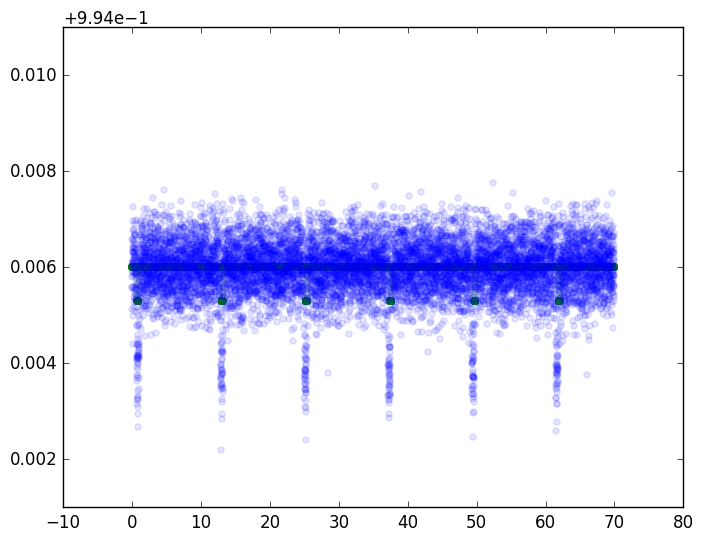

(0.995,1.005)

In [61]:
time_hires = collect(linspace(minimum(time),maximum(time),100000))

scatter(time_hires,transit_model_impact(time_hires,best_mcmc),color="green", alpha=0.1)

scatter(time,mean_flux, color="blue", alpha=0.1)
ylim(0.995,1.005)

# Optim fitting

In [ ]:
# params = [rp/rs, b, v, period, toff] where d = a/rstar
params = [0.05, 0.5, 5.0, best_period, 2.0]
optimum = optimize(transit_loglike_impact_optim, params, method=:gradient_descent)

In [ ]:
# params = [rp/rs, d, ecc, varpi, inc, period] where d = a/rstar
best = optimum.minimum

# Plot phase-folded light curve using best fit parameters

In [62]:
data_fold = copy(data)
data_fold[:,1] = mod(time - time[1], best_mcmc[4]);
data_fold = fastsortrows(data_fold,[1]);

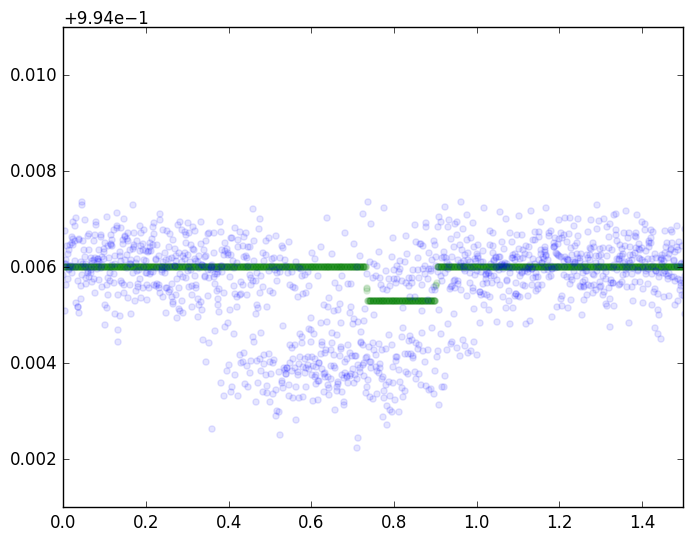

(0.0,1.5)

In [63]:
scatter(data_fold[:,1],transit_model_impact(data_fold[:,1],best_mcmc),color="green",alpha=0.1)
scatter(data_fold[:,1],data_fold[:,2]/mean(data_fold[:,2]),color="blue",alpha=0.1)
ylim(0.995,1.005)
xlim(0.,1.5)

In [ ]:
params = [0.05, 0.95, 1.0, 12.0, 6.0]

time_hires = collect(linspace(0,12.0,10000))

scatter(time_hires,transit_model_impact(time_hires,params),color="green")

In [ ]:
mod(0,12.)+6.0